In [17]:
import gym
from gym import Env
from gym.spaces import Discrete, Box, Tuple
import random
import numpy as np
import time
import cv2
from matplotlib import pyplot as plt

In [18]:
grid_rows = 4
grid_cols = 4
start_location = (0,0)
end_location = (3,3)
obstacles = ((1,0),(2,3))
max_steps = 100

actions = {
    0 : (0,1),  # North
    1 : (0,-1), # South
    2 : (1,0),  # East
    3 : (-1,0)  # West
}


class State(Env):

    def __init__(self):

        #Actions we can take: N, S, E, W
        self.action_space = Discrete(4)
        # 2D Grid
        self.observation_space = Discrete(16)
        # Set start location
        self.state = start_location
        # Set max steps
        self.max_steps = max_steps
        print("Agent start location is:",self.state)

    def check(self):
        print(self.state[0])

    def step(self, action):

        # Apply action
        self.state_new = tuple([sum(x) for x in zip(self.state,actions[action])])
        reward = 0
        
        # check if Agent moved out of bounds
        if self.state_new[0] not in range(0,grid_rows) or self.state_new[1] not in range(0,grid_cols):
            self.state = self.state
            print("Agent moved out of bounds. Position reset.")

        # check if Agent travelled through an obstacle
        elif self.state_new in obstacles:
            self.state = self.state_new 
            reward = -11
            print("Agent travelled through obstacle.")

        else:
            self.state = self.state_new      
            print("Agent moved to new position")


        self.max_steps -= 1

        # Check if Agent reached goal location
        if self.state == end_location:
            reward = 1
            done = True
        # check if max steps reached
        elif self.max_steps <= 0:
            done = True
        else:
            done = False

        info = {}
        return self.state, reward, done, info
            
    
    def render(self):

        image = np.ones((400, 400, 3), dtype=np.uint8) * 255

        #image = cv2.putText(image,"Hello", org=(100,100),fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1 ,color=(0,0,0), thickness=2)

        h, w, _ = image.shape
        rows, cols = (4,4)
        dy, dx = h / rows, w / cols

        # draw vertical lines
        for x in np.linspace(start=dx, stop=w-dx, num=cols-1):
            x = int(round(x))
            cv2.line(image, (x, 0), (x, h), color=(0, 0, 0), thickness=1)

        # draw horizontal lines
        for y in np.linspace(start=dy, stop=h-dy, num=rows-1):
            y = int(round(y))
            cv2.line(image, (0, y), (w, y), color=(0, 0, 0), thickness=1)



        image = cv2.rectangle(img=image,
            pt1=(int(end_location[0]*100), int(end_location[1])*100),
            pt2=(int(end_location[0]*100+100), int(end_location[1])*100+100),
            color=(0, 128, 0),
            thickness=-1)

        image = cv2.rectangle(img=image,
            pt1=(int(start_location[0]*100), int(start_location[1])*100),
            pt2=(int(start_location[0]*100+100), int(start_location[1])*100+100),
            color=(225, 165, 0),
            thickness=-1)

        for obstacle in obstacles:
            image = cv2.rectangle(img=image,
                pt1=(int(obstacle[0]*100), int(obstacle[1])*100),
                pt2=(int(obstacle[0]*100+100), int(obstacle[1])*100+100),
                color=(255, 0, 255),
                thickness=-1)
            
        pos_x, pos_y = self.state   
        image = cv2.circle(img=image,
            center=((int(pos_x)*100)+50, (int(pos_y)*100)+50),
            radius=50,
            color=(255, 0, 0),
            thickness=-1)
        
        cv2.imshow("GridEnv2D", image)
        if cv2.waitKey(100) & 0xFF == ord('q'):
            return
    def reset(self):
        self.state = start_location
        self.max_steps = max_steps


In [19]:
class Agent:

    def __init__(self):
        self.states = []
        self.State = State()
        self.actions = [0, 1, 2, 3]
        self.lr = 0.2
        self.exp_rate = 0.9
        self.decay_gamma = 0.9   

        #initlialize Q table

        self.Qvalues = {}   
        for i in range(grid_rows):
            for j in range(grid_cols):
                self.Qvalues[(i,j)] = {}
                for a in self.actions:
                    self.Qvalues[(i,j)][a] = 0

    def chooseAction(self):
        mx_nxt_rwd = 0
        action = ""

        if np.random.uniform(0,1) <= self.exp_rate:
            action = np.random.choice(self.actions)
            print("EXPLORE")
        else:
            action = max(self.Qvalues[self.State.state])
            for a in self.actions:
                current_pos = self.State.state
                nxt_reward = self.Qvalues[current_pos][a]
                if nxt_reward >= mx_nxt_rwd:
                    action = a
                    mx_nxt_rwd = nxt_reward

            print("Action chosen:",action)
            print("Q-value of chosen action",mx_nxt_rwd)
            print("EXPLOIT")
        return action
    
    def train(self, episodes = 10):
        self.scores = []
        for episode in range(1, episodes+1):
            self.State.reset()
            state = start_location
            done = False
            score = 0
            moves = 0
            locations = []
            self.exp_rate -= 0.005
            
            while not done:
                #self.State.render()
                print("Step", moves)
                action = self.chooseAction()
                # take action
                n_state, reward, done, info = self.State.step(action)
                print(n_state)
                old_value = self.Qvalues[state][action]
                next_max = max(self.Qvalues[n_state].values())
                print(next_max)
                new_value = (1 - self.lr) * old_value + self.lr *(reward + self.decay_gamma * next_max)
                self.Qvalues[state][action] = new_value
                state = n_state
                locations.append(n_state)
                score += reward
                moves += 1
            print('Episode:{} Score:{} Moves:{} Locations:{} Eps Greedy:{}'.format(episode,\
                                             score, moves, locations,self.exp_rate))
            self.scores.append(score)
            # self.State.render()
            # cv2.waitKey(1000) # waits until a key is pressed
            # cv2.destroyAllWindows() # destroys the window showing image
        self.learned_Qvalues = self.Qvalues

    def test(self, episodes = 10):

        # same process as train() except Q values are not updated, and all actions are greedy

        self.scores = []
        for episode in range(1, episodes+1):
            self.State.reset()
            state = start_location
            done = False
            score = 0
            moves = 0
            locations = []
            
            while not done:
                self.State.render()
                print("Step", moves)
                action = self.chooseAction()
                #print("Chosen action:",action,type(action))
                print("current position {} action {}".format(state, action))
                n_state, reward, done, info = self.State.step(action)
                print(n_state)                
                state = n_state
                locations.append(n_state)
                score += reward
                moves += 1
            print('Episode:{} Score:{} Moves:{} Locations:{} Eps Greedy:{}'.format(episode,\
                                             score, moves, locations,self.exp_rate))
            self.scores.append(score)
            self.State.render()
            cv2.waitKey(500) # waits until a key is pressed
            cv2.destroyAllWindows() # destroys the window showing image

                 
        

In [20]:
ag = Agent()
print("initial Q-values ... \n")
print(ag.Qvalues)


Agent start location is: (0, 0)
initial Q-values ... 

{(0, 0): {0: 0, 1: 0, 2: 0, 3: 0}, (0, 1): {0: 0, 1: 0, 2: 0, 3: 0}, (0, 2): {0: 0, 1: 0, 2: 0, 3: 0}, (0, 3): {0: 0, 1: 0, 2: 0, 3: 0}, (1, 0): {0: 0, 1: 0, 2: 0, 3: 0}, (1, 1): {0: 0, 1: 0, 2: 0, 3: 0}, (1, 2): {0: 0, 1: 0, 2: 0, 3: 0}, (1, 3): {0: 0, 1: 0, 2: 0, 3: 0}, (2, 0): {0: 0, 1: 0, 2: 0, 3: 0}, (2, 1): {0: 0, 1: 0, 2: 0, 3: 0}, (2, 2): {0: 0, 1: 0, 2: 0, 3: 0}, (2, 3): {0: 0, 1: 0, 2: 0, 3: 0}, (3, 0): {0: 0, 1: 0, 2: 0, 3: 0}, (3, 1): {0: 0, 1: 0, 2: 0, 3: 0}, (3, 2): {0: 0, 1: 0, 2: 0, 3: 0}, (3, 3): {0: 0, 1: 0, 2: 0, 3: 0}}


In [21]:

ag.train(100)
print("latest Q-values ... \n")
print(ag.Qvalues)

Step 0
EXPLORE
Agent moved to new position
(0, 1)
0
Step 1
EXPLORE
Agent moved out of bounds. Position reset.
(0, 1)
0
Step 2
EXPLORE
Agent moved to new position
(1, 1)
0
Step 3
Action chosen: 3
Q-value of chosen action 0
EXPLOIT
Agent moved to new position
(0, 1)
0
Step 4
EXPLORE
Agent moved to new position
(0, 2)
0
Step 5
EXPLORE
Agent moved out of bounds. Position reset.
(0, 2)
0
Step 6
EXPLORE
Agent moved to new position
(0, 3)
0
Step 7
EXPLORE
Agent moved out of bounds. Position reset.
(0, 3)
0
Step 8
EXPLORE
Agent moved out of bounds. Position reset.
(0, 3)
0
Step 9
Action chosen: 3
Q-value of chosen action 0.0
EXPLOIT
Agent moved out of bounds. Position reset.
(0, 3)
0
Step 10
EXPLORE
Agent moved out of bounds. Position reset.
(0, 3)
0
Step 11
EXPLORE
Agent moved out of bounds. Position reset.
(0, 3)
0.0
Step 12
EXPLORE
Agent moved to new position
(0, 2)
0.0
Step 13
EXPLORE
Agent moved to new position
(0, 3)
0.0
Step 14
EXPLORE
Agent moved out of bounds. Position reset.
(0, 3)
0

[-44, -21, -55, -32, -10, 1, -32, -10, -21, -21, -76, -21, -65, -21, -43, -21, -32, -21, -43, -10, -21, -43, 1, -10, -10, -32, -32, -32, -43, -10, -32, -54, -10, 1, 1, 1, 1, -10, 1, -10, -21, 1, -10, 1, -21, 1, 1, -21, -21, -21, -10, 1, 1, -21, 1, -10, 1, 1, 1, 1, -21, 1, -21, 1, 1, 1, 1, -10, 1, -10, 1, -10, -21, -32, -21, 1, -10, 1, 1, -10, 1, 1, -10, -10, 1, 1, -10, -10, 1, -10, 1, 1, 1, 1, 1, 1, 1, -10, 1, -10]
100


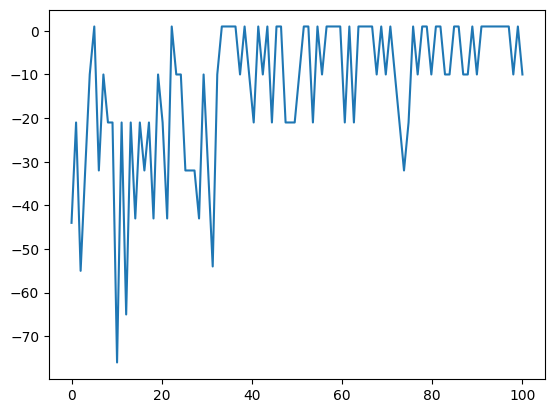

In [22]:
print(ag.scores)
print(len(ag.scores))
x = np.linspace(0, len(ag.scores),len(ag.scores))
y = ag.scores
plt.plot(x,y)
plt.show()

Learned Q-values ... 

{(0, 0): {0: 0.590294282872309, 1: 0.5203639118726657, 2: -10.452832967096516, 3: 0.519819849579043}, (0, 1): {0: 0.5598783330760195, 1: 0.522239566892387, 2: 0.6560021896559722, 3: 0.5471074946402047}, (0, 2): {0: 0.2176822887864586, 1: 0.2888721746160945, 2: 0.7004579745037016, 3: 0.18812092008813855}, (0, 3): {0: 0.05766923833782904, 1: 0.44700824346435597, 2: 0.2242257477411962, 3: 0.030107719369695928}, (1, 0): {0: 0.38825589151892304, 1: 0.09653920649911535, 2: 0.6528846501407696, 3: 0.38828465365702874}, (1, 1): {0: 0.6764950218704157, 1: -10.45143169586352, 2: 0.7289837802092453, 3: 0.5578196522117129}, (1, 2): {0: 0.34660176365724626, 1: 0.5818056345789354, 2: 0.8074389858389351, 3: 0.4661150123495665}, (1, 3): {0: 0.18434985454449343, 1: 0.6153076769863988, 2: -9.696135903657986, 3: 0.0531009856569616}, (2, 0): {0: 0.7287098911014089, 1: 0.5501831197281355, 2: 0.7095680388422745, 3: -10.039872748542018}, (2, 1): {0: 0.7871404439466028, 1: 0.643201815165

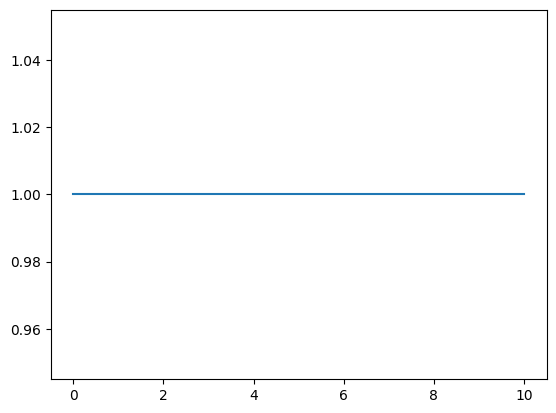

In [23]:
ag.exp_rate = 0
print("Learned Q-values ... \n")
print(ag.Qvalues)
ag.test(10)

print(ag.scores)
print(len(ag.scores))
x = np.linspace(0, len(ag.scores),len(ag.scores))
y = ag.scores
plt.plot(x,y)
plt.show()